# Cistopic analysis

In [1]:
import os
import pycisTopic
from pycisTopic.cistopic_class import create_cistopic_object
pycisTopic.__version__

'2.0a0'

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "SST")

In [4]:
!mkdir -p pycistopic_outputs

In [5]:
## Some meta information
path_to_blacklist = "/tscc/projects/ps-epigen/users/biy022/scmethylhic/genome/hg38_blacklist.v2.bed.gz"

In [6]:
## Prepare the sample_id pd.Dataframe, not sure if this is necessary
meta_df = pd.read_csv("SST_meta_data.tsv", header=0, sep="\t", index_col=0)
meta_df["sample_id"] = "SST"

In [7]:
import scanpy as sc
atac_adata = sc.read_h5ad("SST_atac_matrix.h5ad")

In [8]:
cell_names_tb = pd.read_csv("SST_cell_barcodes.tsv", header=None, sep="\t")
cell_names = cell_names_tb[0].tolist()
region_names_tb = pd.read_csv("SST_atac_regions.tsv", header=None, sep="\t")
region_names = region_names_tb[0].tolist()
region_names = ["{}:{}-{}".format(*x.split("-")) for x in region_names]

In [9]:
cistopic_object = create_cistopic_object(
    fragment_matrix=atac_adata.X.T.tocsr(),
    cell_names=cell_names,
    region_names=region_names,
    path_to_blacklist=path_to_blacklist,
    project="SST",
    tag_cells=False
)

2025-03-22 19:30:31,238 cisTopic     INFO     Removing blacklisted regions
2025-03-22 19:30:32,722 cisTopic     INFO     Creating CistopicObject
2025-03-22 19:30:34,572 cisTopic     INFO     Done!


In [10]:
cistopic_object.add_cell_data(meta_df)

Columns ['sample_id'] will be overwritten


In [11]:
print(cistopic_object)

CistopicObject from project SST with n_cells × n_regions = 57613 × 552286


In [12]:
import pickle
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

In [13]:
# dispatch models to different clusters
!mkdir -p pycistopic_slurm/

In [14]:
slurm_script_template = (
    "#!/bin/bash\n"
    "#SBATCH -p condo\n"
    "#SBATCH -q condo\n"
    "#SBATCH -J {0}\n"
    "#SBATCH -N 3\n"
    "#SBATCH -c 8\n"
    "#SBATCH --mem 300G\n"
    "#SBATCH -t 8:00:00\n"
    "#SBATCH -o /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/SST/pycistopic_slurm/{0}.out\n"
    "#SBATCH -e /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/SST/pycistopic_slurm/{0}.err\n"
    "#SBATCH --mail-user biy022@health.ucsd.edu\n"
    "#SBATCH --mail-type FAIL\n"
    "#SBATCH -A csd772\n"
    "\n"
    "set -e\n"
    "source ~/.bashrc\n"
    "conda activate scenicplus\n"
    "\n"
    "cd /tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/SST/\n"
    "python3 02.1_mallet_script.py {0} "
    "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/SST/pycistopic_outputs/cistopic_object.pickle\n"
)

In [15]:
for n_topic in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    with open("pycistopic_slurm/model_{}_slurm.sh".format(n_topic), "w") as f:
        f.write(slurm_script_template.format(n_topic))

In [16]:
# Run models in cluster

## Run cistopic

In [4]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

In [5]:
models = []
for file in os.listdir("pycistopic_outputs"):
    if file.startswith("Topic") and file.endswith(".pkl"):
        model = pickle.load(open(os.path.join("pycistopic_outputs/", file), "rb"))
        models.append(model)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-23 11:15:20,605	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
pickle.dump(
    models,
    open("pycistopic_outputs/cistopic_models.pkl", "wb")
)

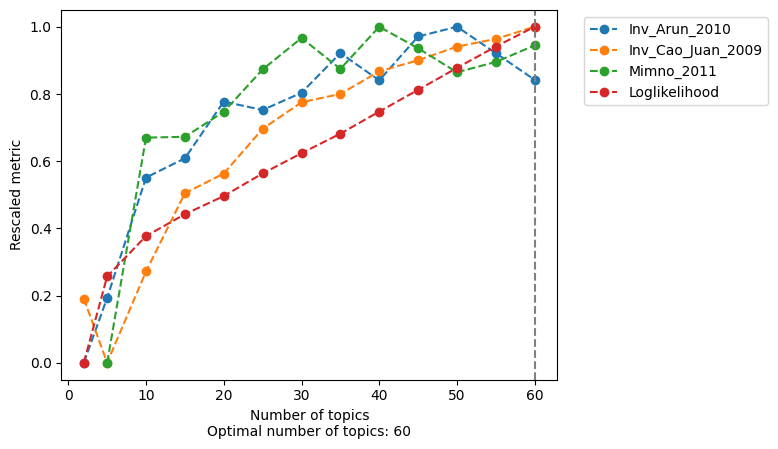

In [7]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(models, return_model = True)

In [8]:
cistopic_object.add_LDA_model(model)
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

## Clustering with cell to topics distributions

In [9]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap,
    harmony
)

In [10]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

In [11]:
find_clusters(
    cistopic_object,
    target="cell",
    k=20,
    res=[0.2, 0.4, 0.6, 0.8, 1.0],
    prefix="pycisTopic_",
    scale=True
)

2025-03-23 11:15:53,571 cisTopic     INFO     Finding neighbours


In [12]:
run_umap(cistopic_object, target="cell", scale=True)

2025-03-23 11:17:01,671 cisTopic     INFO     Running UMAP


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


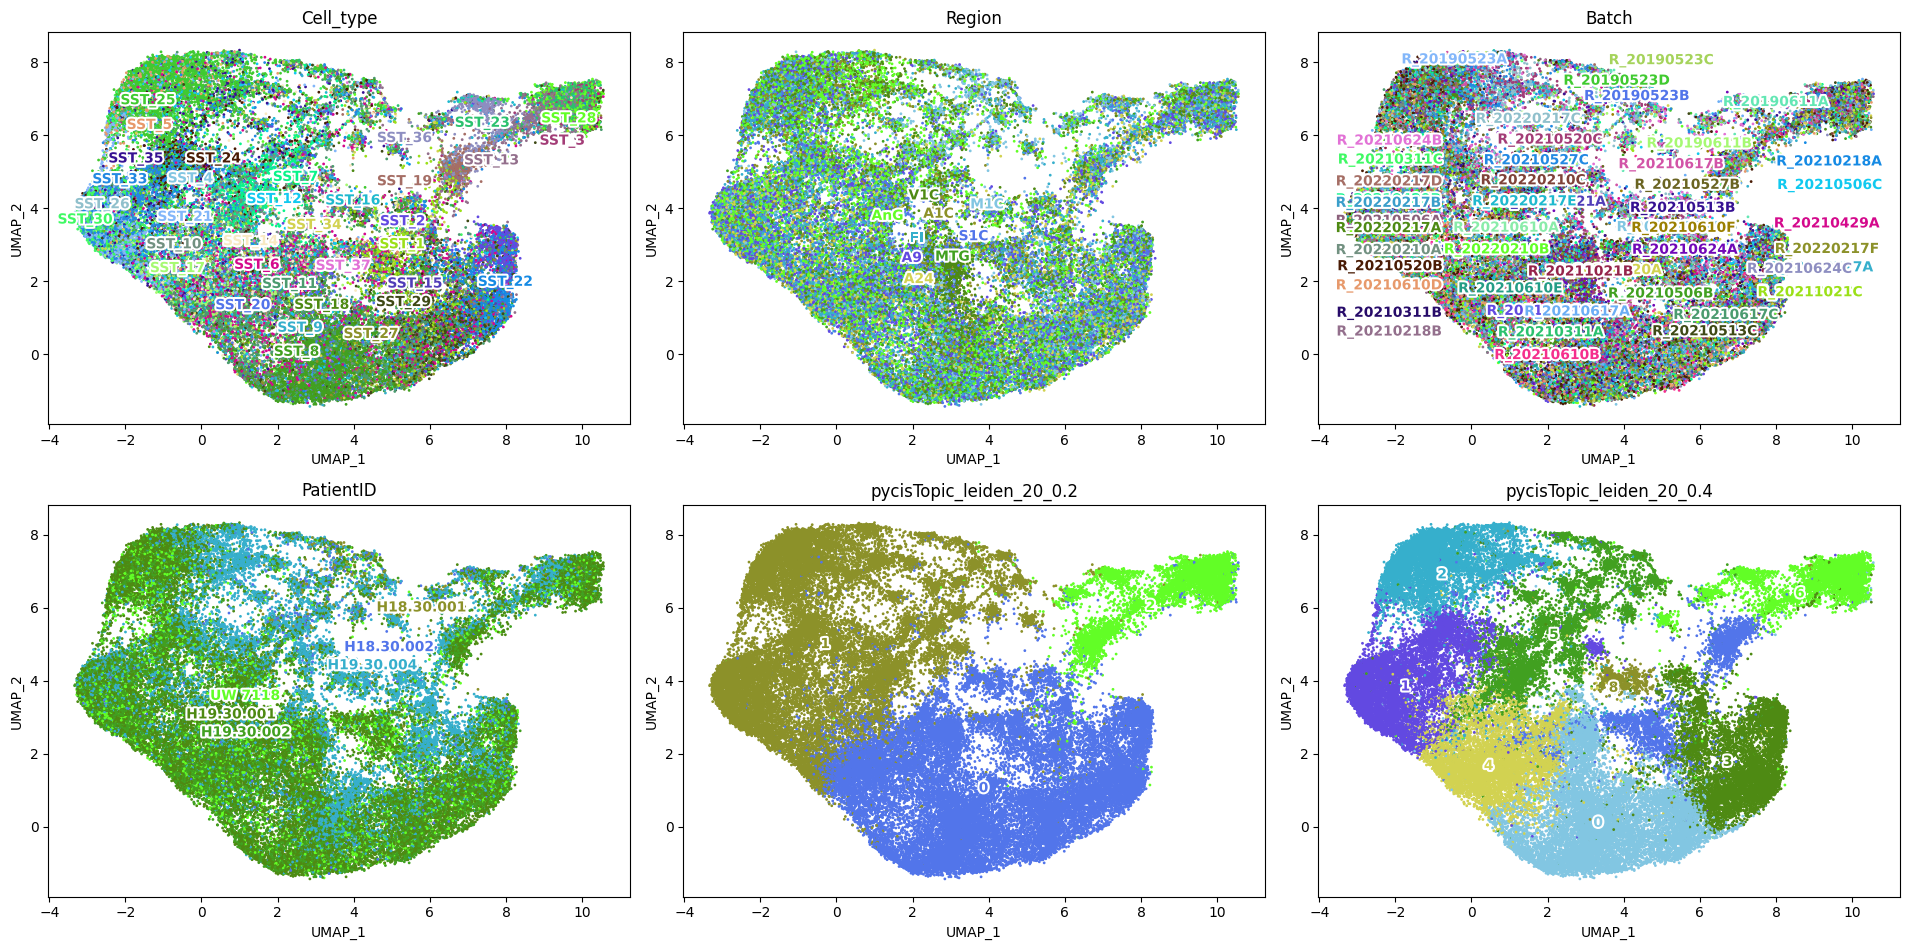

In [13]:
plot_metadata(
    cistopic_object,
    reduction_name="UMAP",
    variables=[
        "Cell_type", 
        "Region", 
        "Batch", 
        "PatientID",
        "pycisTopic_leiden_20_0.2",
        "pycisTopic_leiden_20_0.4"
    ],
    target="cell",
    num_columns=3,
    text_size=10,
    dot_size=1,
    show_legend=False
)

In [14]:
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

## Topic binarization

In [15]:
from pycisTopic.topic_binarization import binarize_topics

In [16]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

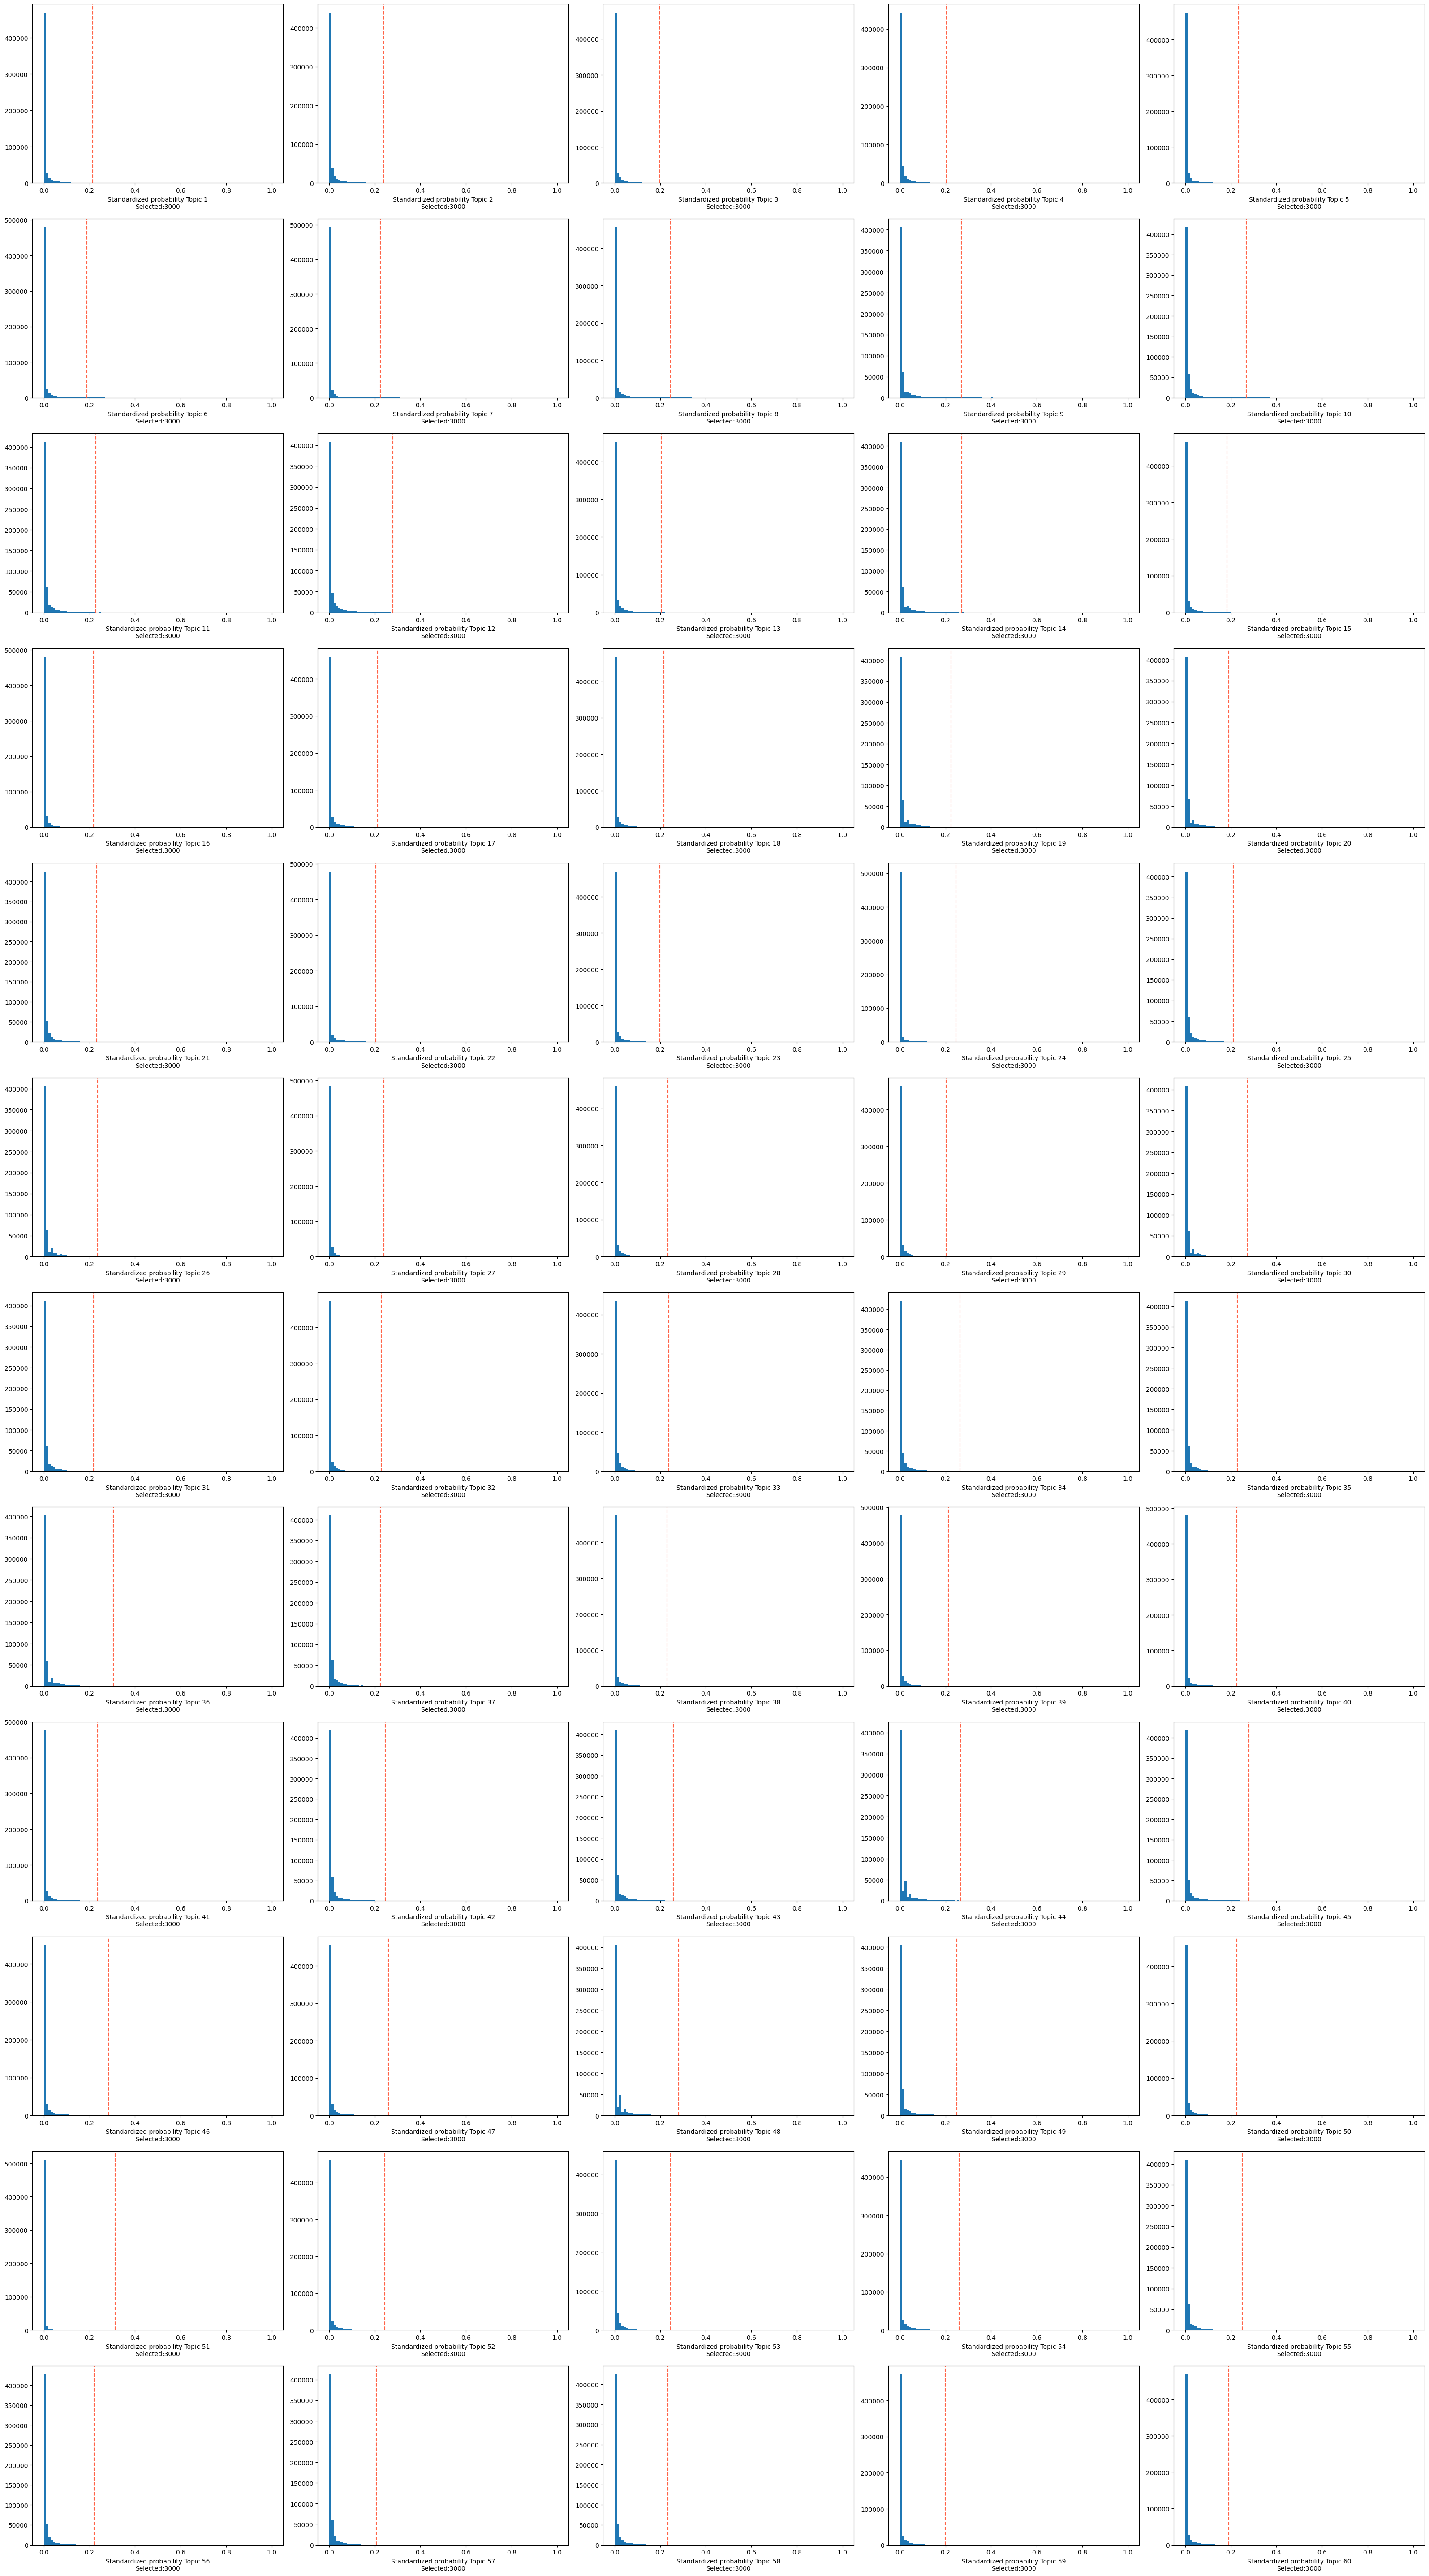

In [17]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_object, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)

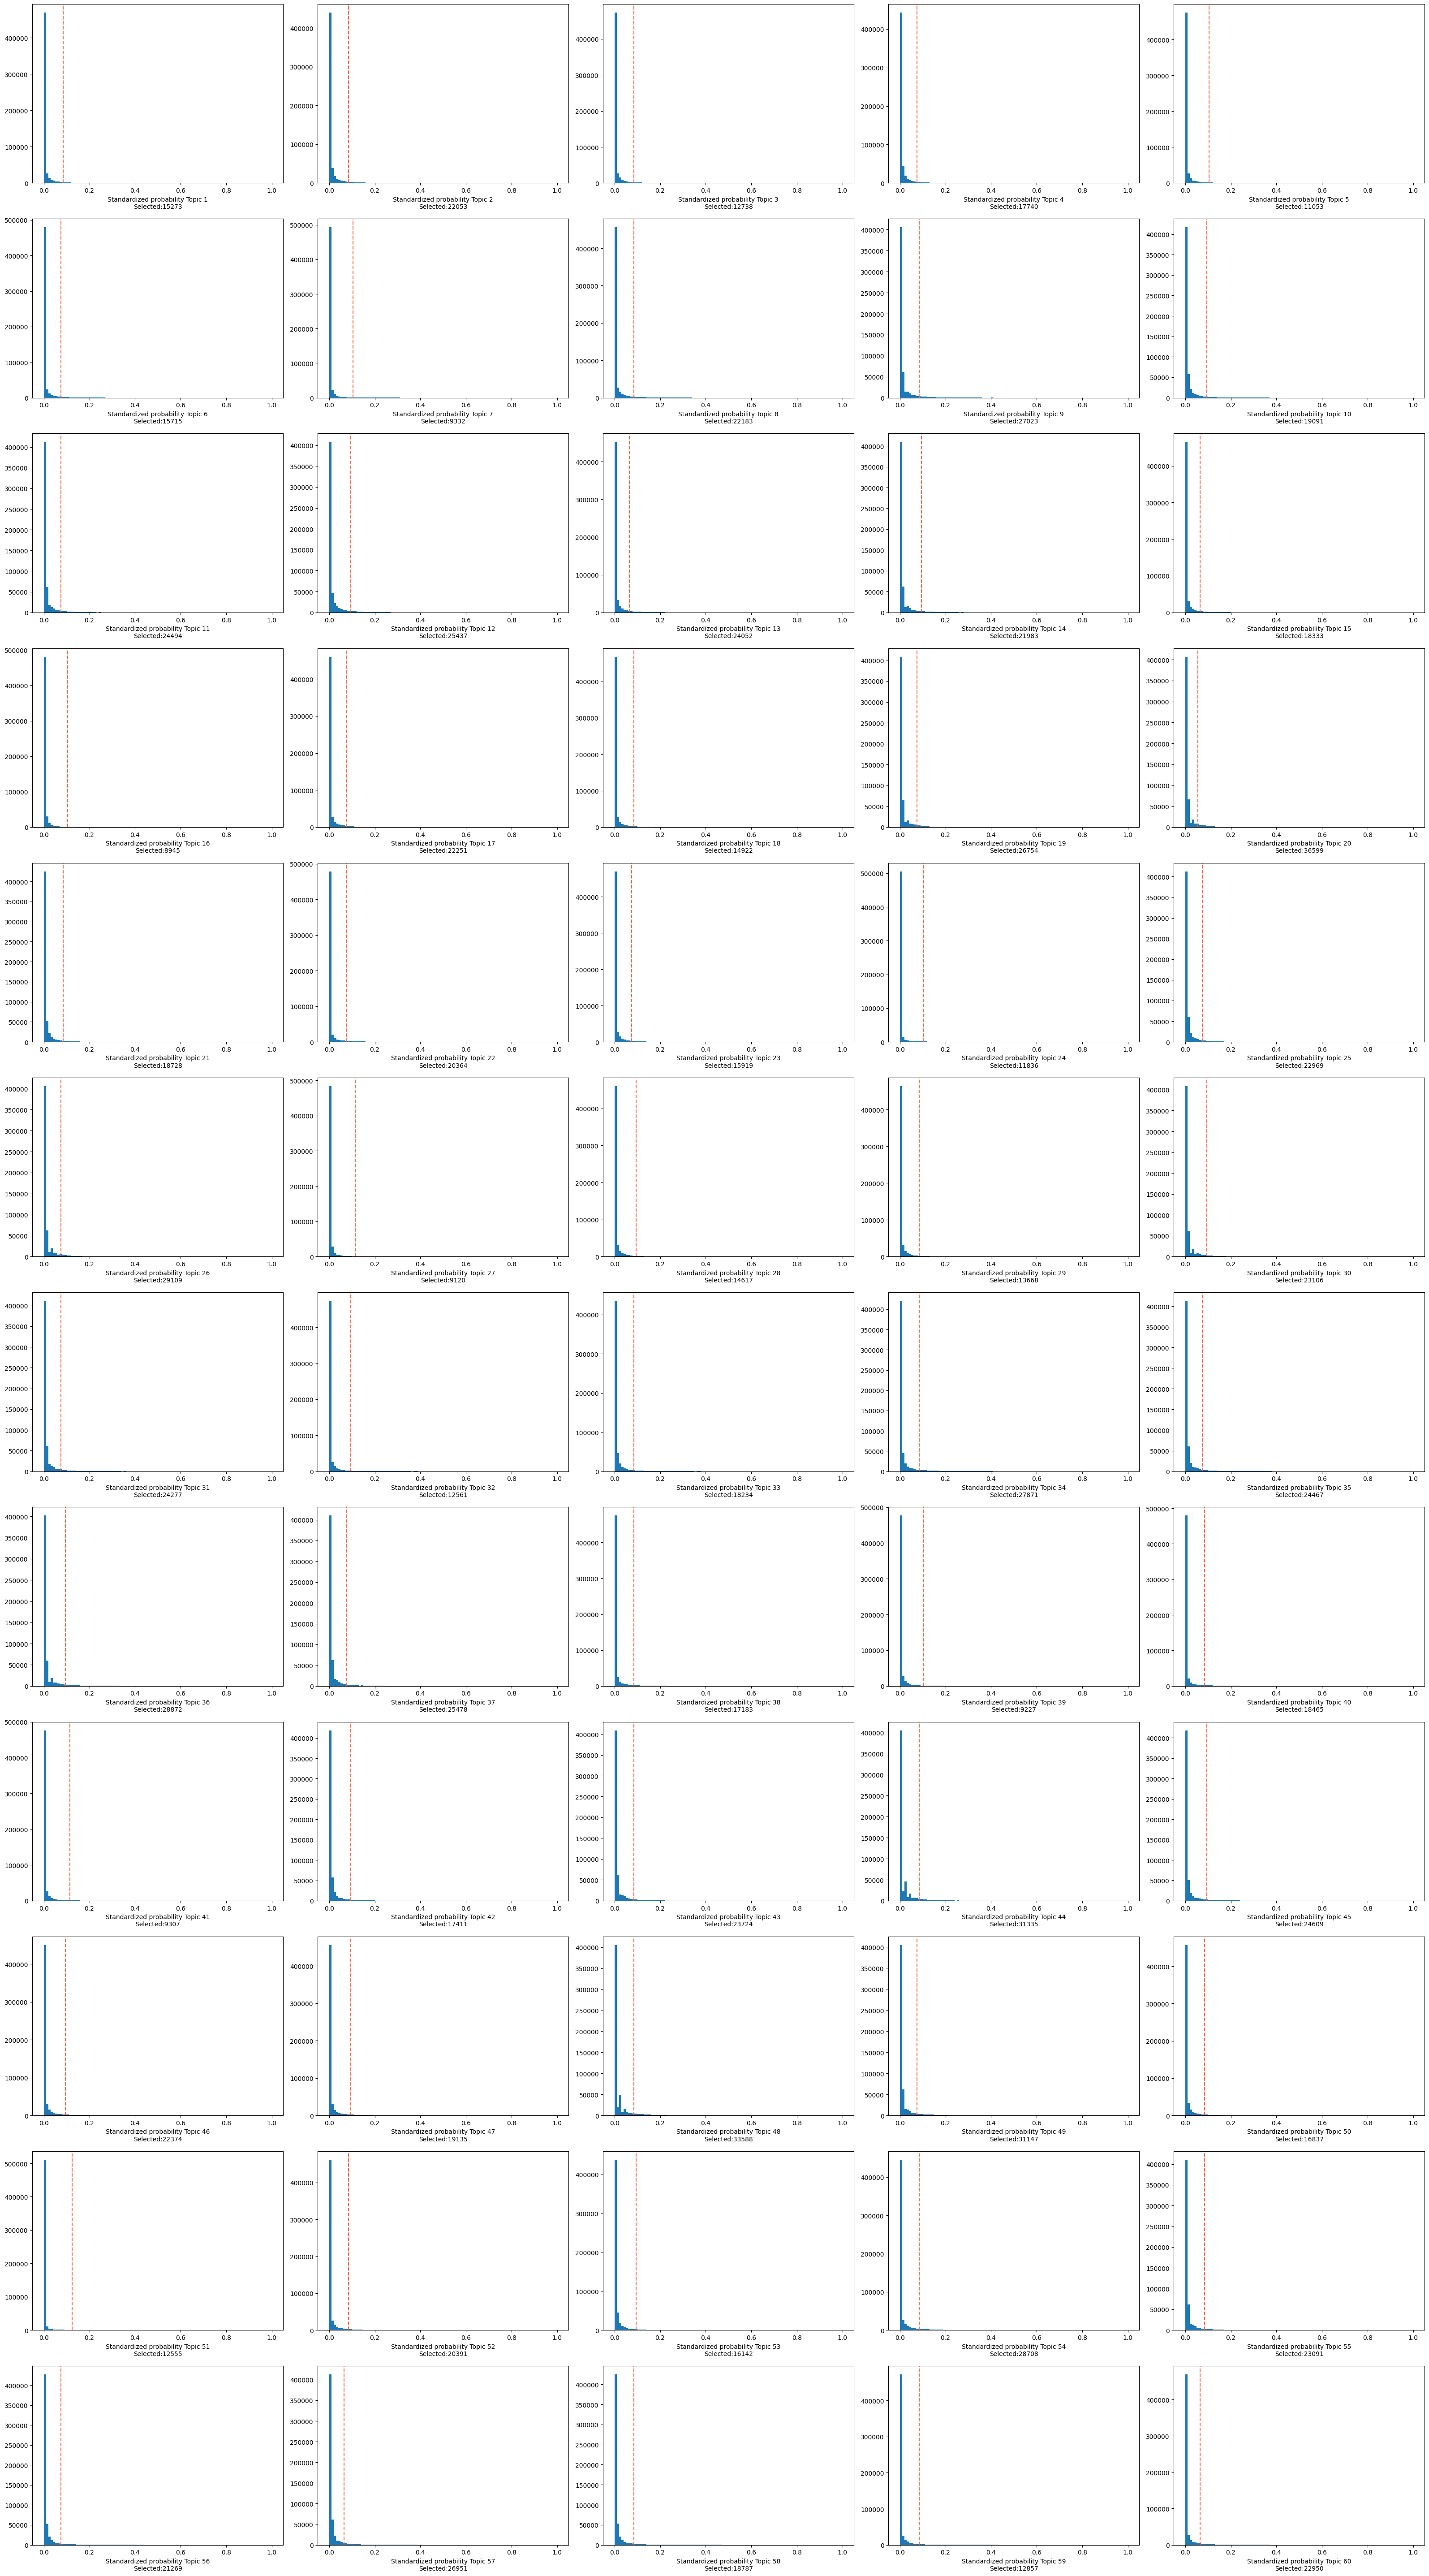

In [18]:
region_bin_topics_otsu = binarize_topics(
    cistopic_object, method='otsu',
    plot=True, num_columns=5
)

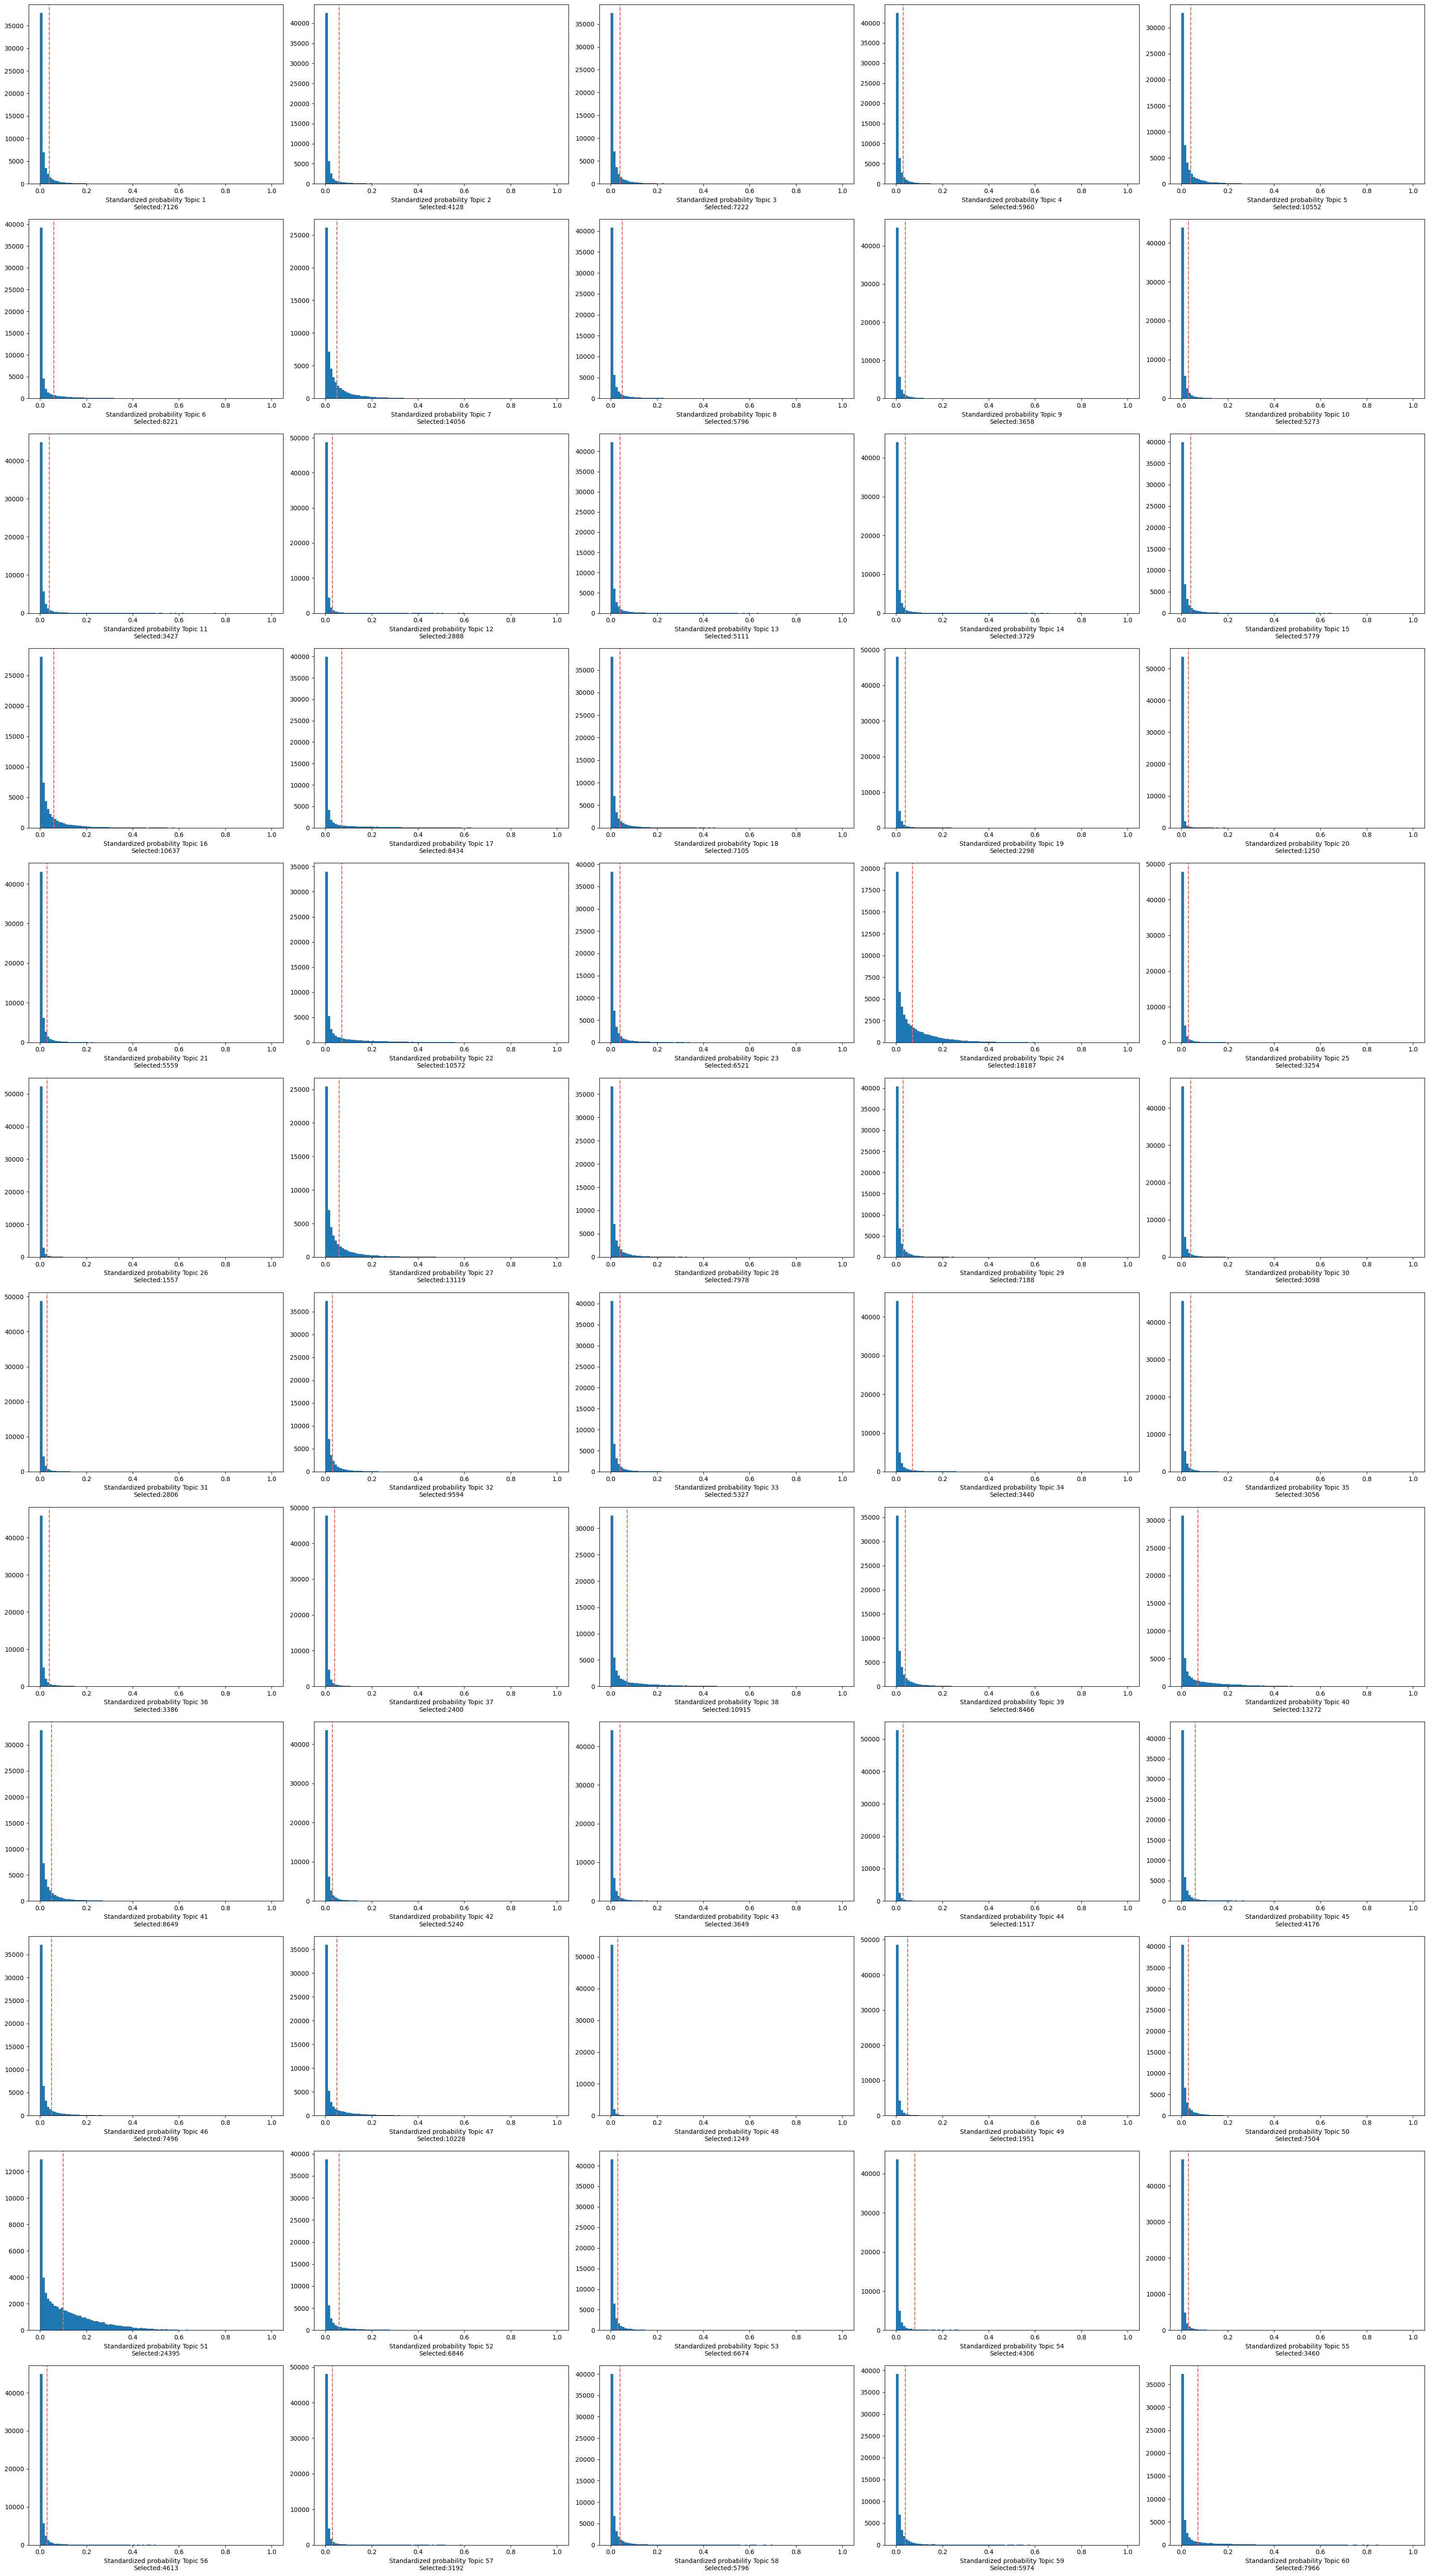

In [19]:
binarized_cell_topic = binarize_topics(
    cistopic_object,
    target="cell",
    method="li",
    plot=True,
    num_columns=5, 
    nbins=100
)

In [20]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img

In [21]:
topic_qc_metrics = compute_topic_metrics(cistopic_object)

In [22]:
fig_dict={}
fig_dict['CoherenceVSAssignments'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSMarginal_dist'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSGini_index'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Gini_index', 
    var_color='Gini_index', plot=False, return_fig=True
)

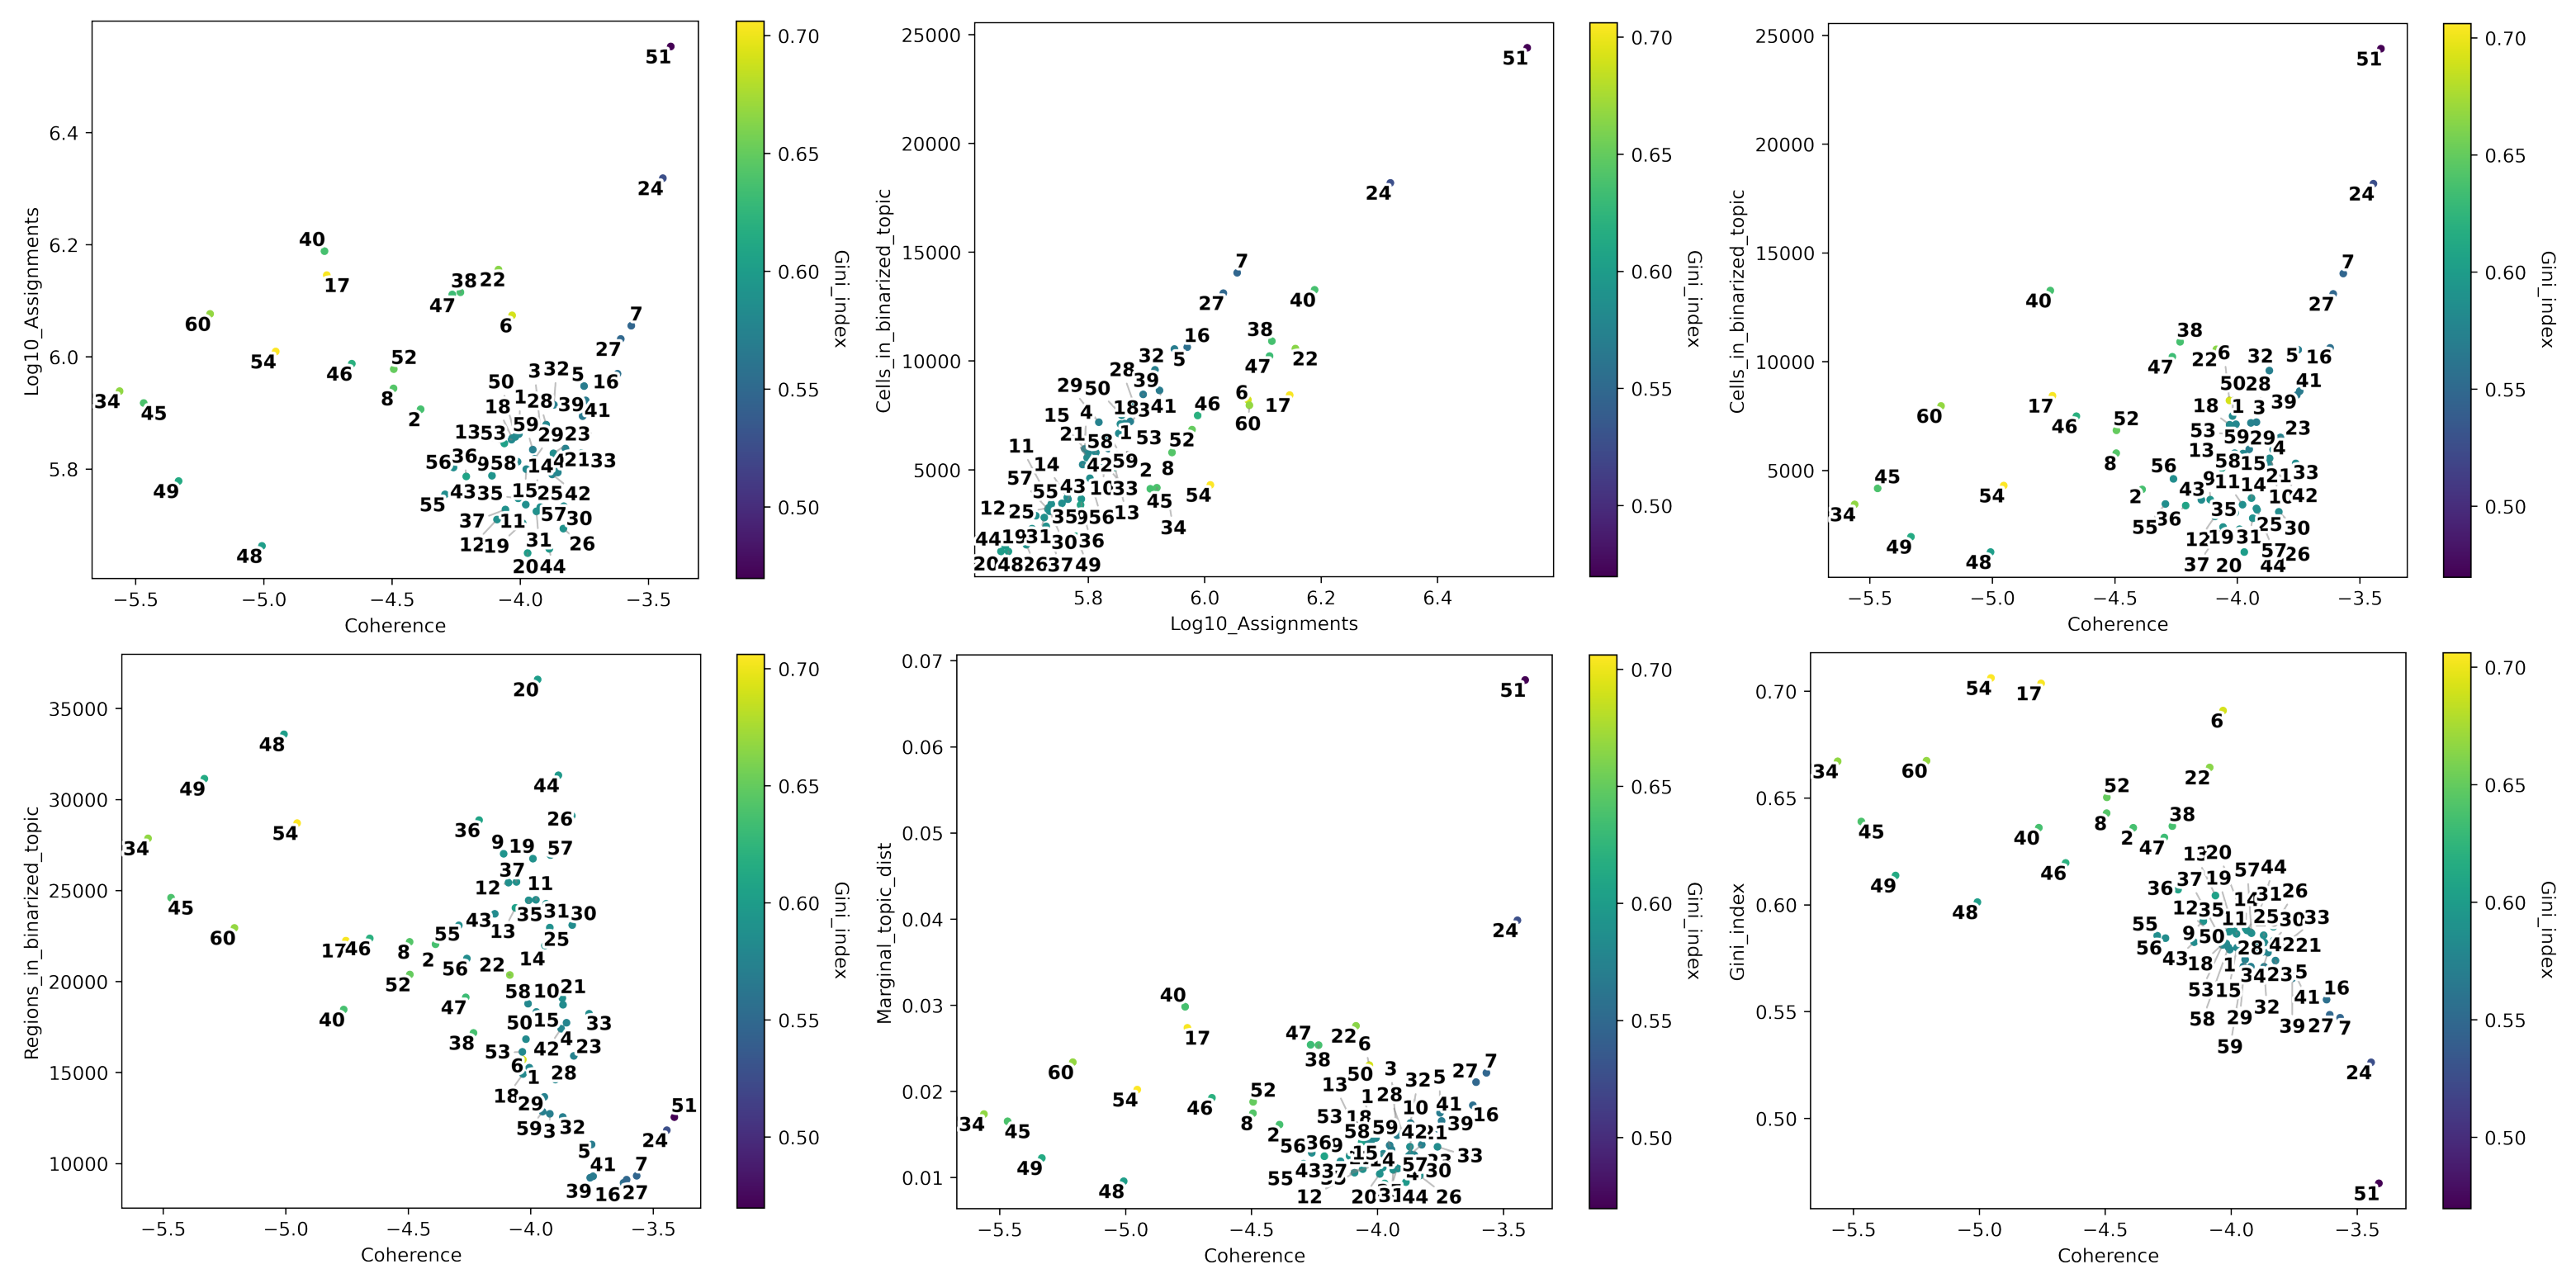

In [23]:
fig = plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_])
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

In [24]:
topic_annot = topic_annotation(
    cistopic_object,
    annot_var="Cell_type",
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr=0.2
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


## DAR

In [25]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
import numpy as np

In [26]:
imputed_acc_obj = impute_accessibility(
    cistopic_object,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2025-03-23 11:20:39,762 cisTopic     INFO     Imputing region accessibility
2025-03-23 11:20:39,763 cisTopic     INFO     Impute region accessibility for regions 0-20000
2025-03-23 11:20:46,167 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2025-03-23 11:20:52,552 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2025-03-23 11:20:58,955 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2025-03-23 11:21:05,334 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2025-03-23 11:21:11,723 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2025-03-23 11:21:18,097 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2025-03-23 11:21:24,479 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2025-03-23 11:21:30,782 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2025-03-23 11:21:37,106 cisTopic     

In [27]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2025-03-23 11:23:35,865 cisTopic     INFO     Normalizing imputed data
2025-03-23 11:25:45,176 cisTopic     INFO     Done!


2025-03-23 11:25:45,181 cisTopic     INFO     Calculating mean
2025-03-23 11:26:12,343 cisTopic     INFO     Calculating variance


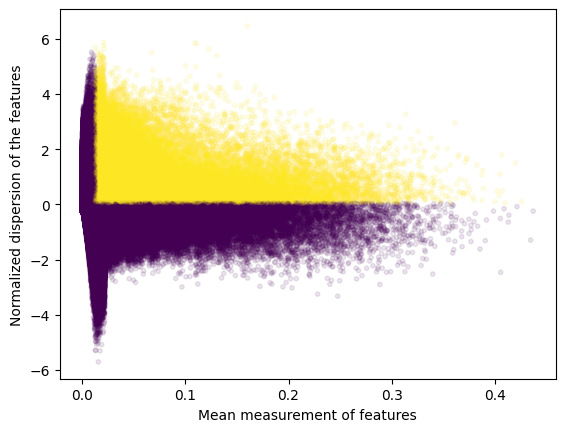

2025-03-23 11:31:43,481 cisTopic     INFO     Done!


In [28]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp=0.05,
    min_mean=0.0125,
    max_mean=3,
    max_disp=np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

In [29]:
len(variable_regions)

56903

In [30]:
markers_dict = find_diff_features(
    cistopic_object,
    imputed_acc_obj,
    variable="Cell_type",
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1),
    n_cpu=20,
    _temp_dir="/tscc/nfs/home/biy022/tmp/"
)

2025-03-23 11:31:58,764	INFO worker.py:1724 -- Started a local Ray instance.


2025-03-23 11:32:00,972 cisTopic     INFO     Subsetting data for SST_1 (1396 of 57613)
2025-03-23 11:32:05,071 cisTopic     INFO     Computing p-value for SST_1
2025-03-23 11:32:16,378 cisTopic     INFO     Computing log2FC for SST_1
2025-03-23 11:32:18,010 cisTopic     INFO     SST_1 done!
2025-03-23 11:32:18,030 cisTopic     INFO     Subsetting data for SST_10 (1199 of 57613)
2025-03-23 11:32:18,498 cisTopic     INFO     Computing p-value for SST_10
2025-03-23 11:32:27,385 cisTopic     INFO     Computing log2FC for SST_10
2025-03-23 11:32:27,558 cisTopic     INFO     SST_10 done!
2025-03-23 11:32:27,600 cisTopic     INFO     Subsetting data for SST_11 (6676 of 57613)
2025-03-23 11:32:28,140 cisTopic     INFO     Computing p-value for SST_11
2025-03-23 11:32:36,938 cisTopic     INFO     Computing log2FC for SST_11
2025-03-23 11:32:37,116 cisTopic     INFO     SST_11 done!
2025-03-23 11:32:37,155 cisTopic     INFO     Subsetting data for SST_12 (1711 of 57613)
2025-03-23 11:32:37,638 

In [31]:
from pycisTopic.clust_vis import plot_imputed_features

In [32]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

Number of DARs found:
---------------------
  SST_1: 25118
  SST_10: 16142
  SST_11: 25742
  SST_12: 24051
  SST_13: 20847
  SST_14: 21537
  SST_15: 26341
  SST_16: 19255
  SST_17: 20472
  SST_18: 21966
  SST_19: 16749
  SST_2: 17941
  SST_20: 20381
  SST_21: 22472
  SST_22: 21137
  SST_23: 18257
  SST_24: 18613
  SST_25: 22184
  SST_26: 16609
  SST_27: 24796
  SST_28: 18702
  SST_29: 22758
  SST_3: 16677
  SST_30: 19793
  SST_33: 21458
  SST_34: 16378
  SST_35: 22367
  SST_36: 18716
  SST_37: 21330
  SST_4: 4880
  SST_5: 21833
  SST_6: 28290
  SST_7: 16798
  SST_8: 23947
  SST_9: 24344


## Save region sets

In [33]:
os.makedirs("pycistopic_outputs/region_sets", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/Topics_otsu", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/Topics_top_3k", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/DARs_celltypes", exist_ok = True)

In [34]:
from pycisTopic.utils import region_names_to_coordinates

In [35]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/Topics_otsu/", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [36]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/Topics_top_3k/", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [37]:
for subtype in markers_dict:
    subtype_name = subtype.replace(" ", "_").replace("/", "_")
    region_names_to_coordinates(
        markers_dict[subtype].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/DARs_celltypes/", f"{subtype_name}.bed"),
        sep="\t", header=False, index=False
    )